In [46]:
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Column
from astroquery.mast import Tesscut
from lightkurve import TessTargetPixelFile, TessQualityFlags, TessLightCurve, LombScarglePeriodogram
from lightkurve import search_targetpixelfile, search_tesscut, TessLightCurveFile
from scipy.signal import argrelmax
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from random import randint, sample

Text(0.5, 1.0, 'Light Curve w/ sigma clip=2.5')

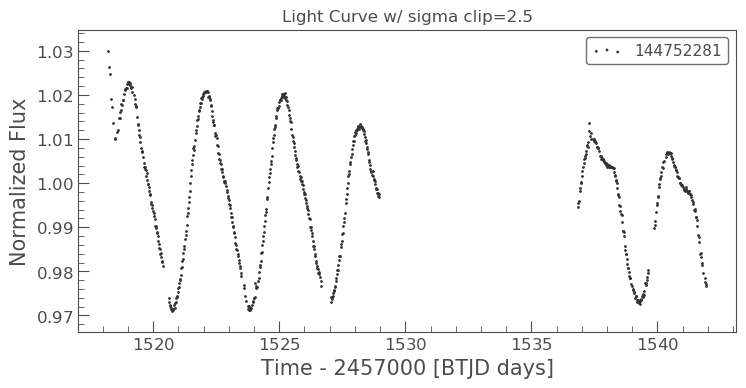

In [21]:
# Import and plot Light Curve 
lc = TessLightCurveFile('DataOutput/LightCurves/TESS_LC_144752281_SEC8.fits').get_lightcurve('FLUX')
lc.remove_outliers(sigma=2.5).scatter()
plt.title('Light Curve w/ sigma clip=2.5')

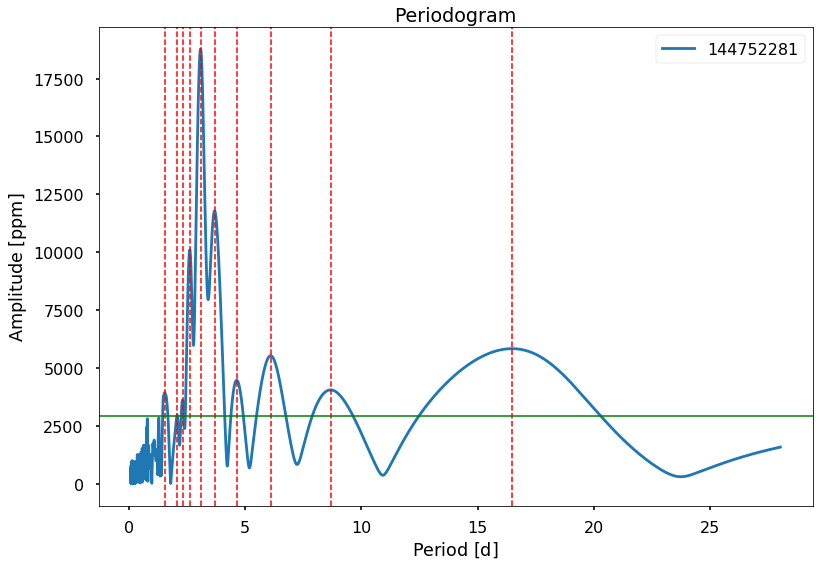

In [141]:
# num_terms is the number of terms for which the fourier expansion is done (how complex are the oscillations?)
num_terms = 1
# Min_period is the minimum detectable period
min_period = 0.1
# max_period is the maximum detectable period
max_period = 28.

ov_sampling = 150

# Get periodogram of clean light curve using the defined parameters
pg = lc.remove_outliers(sigma=2.5).to_periodogram(method='lombscargle', minimum_period=min_period, maximum_period=max_period,
                                                  nterms=num_terms, oversample_factor=ov_sampling)

# Find local maxima in data; most credible periods
peaks = argrelmax(pg.power)[0]
# period_peaks = pg.period[peaks]

# Remove any peak below the 95% power percentile
cut_off_peak = np.percentile(pg.power[peaks], 95)
acceptable_peaks = pg.power[peaks].value > cut_off_peak
new_peaks = peaks[acceptable_peaks]
period_peaks = pg.period[new_peaks]

# Plot periodogram in period domain!!
ax = pg.plot(scale='linear', view='period', style=plt.style.available[-2], title='Periodogram')
# plt.title('Periodogram')

for period_peak in period_peaks:
    plt.axvline(period_peak.value, ls='--', c='red')

plt.axhline(cut_off_peak, c='green')

In [143]:
# Top 5 periodic signals detected
pg.period[pg.power.argsort()][::-1][:5]

<Quantity [3.08971366, 3.08703164, 3.09240034, 3.08435428, 3.0950917 ] d>

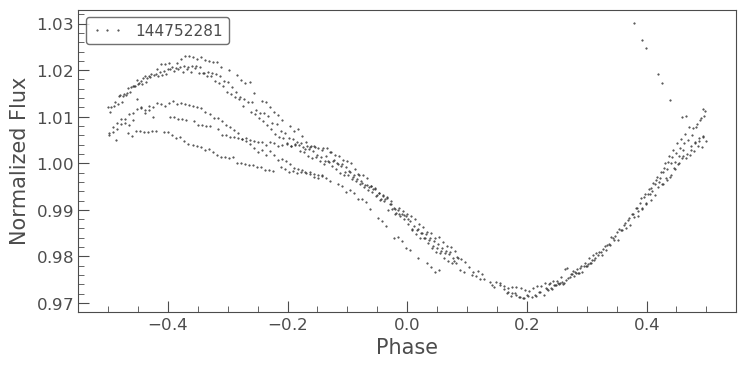

In [153]:
# I think actual period is a bit above 6 days.
lc.remove_outliers(sigma=2.5).fold(period=pg.period_at_max_power.value).plot(title=f'Folded Light Curve; Period={pg.period_at_max_power.value}', ls='', marker='.')

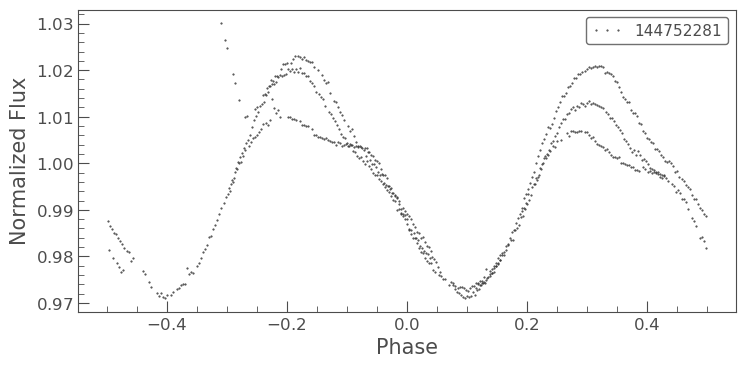

In [152]:
# I think actual period is a bit above 6 days.
lc.remove_outliers(sigma=2.5).fold(period=pg.period_at_max_power.value*2).plot(title=f'Folded Light Curve; Period={pg.period_at_max_power.value}', ls='', marker='.')

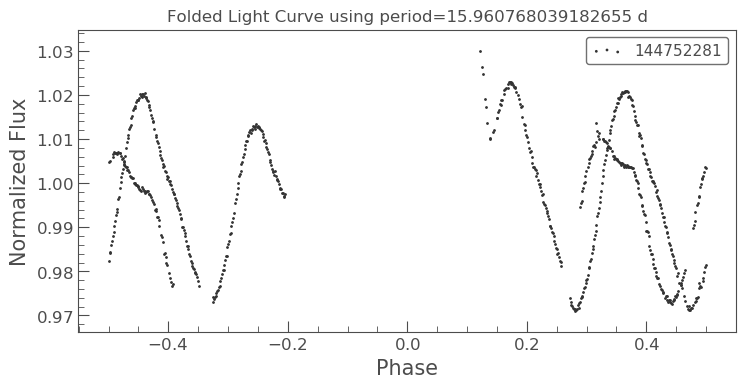

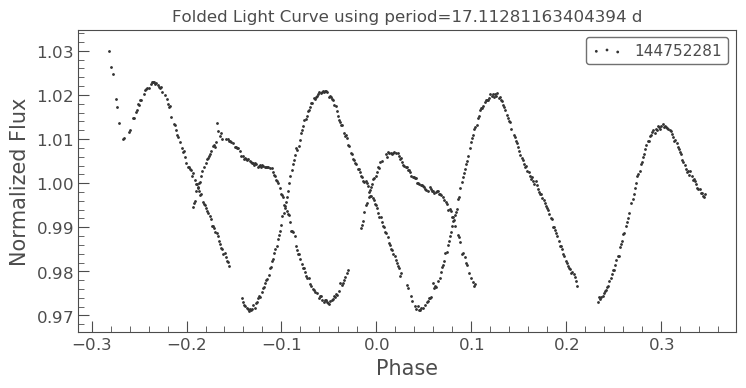

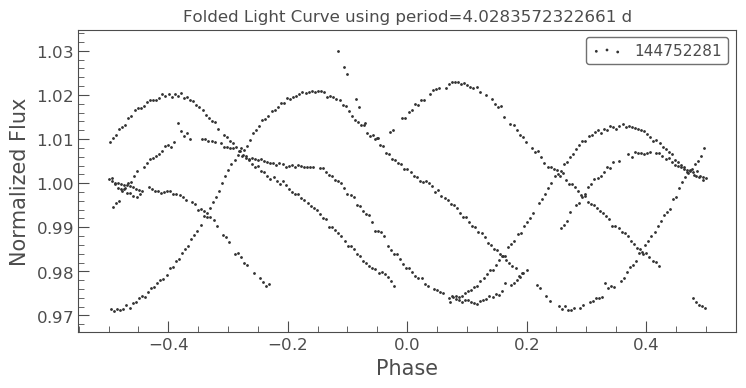

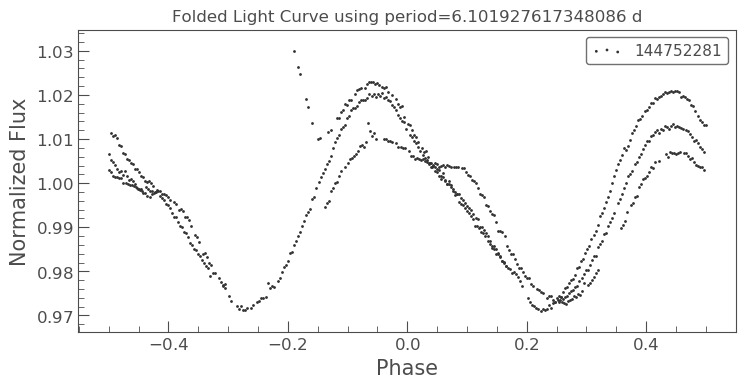

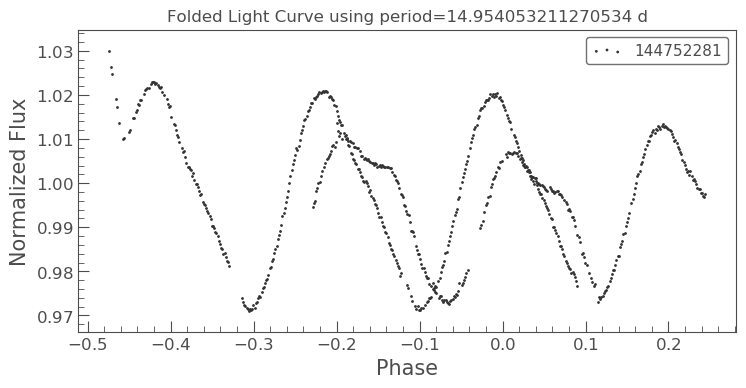

In [38]:
for period in pg.period[pg.power.argsort()][::-1][:5]:
    lc.remove_outliers(sigma=2.5).fold(period=period.value).scatter()
    plt.title(f'Folded Light Curve using period={period}')
    plt.show()

In [ ]:
# SAVE UP TO THIRD PERIOD
# 